# **CIS 5200: Machine Learning**

## **Active learning**


- **Content Creators:** Siyun Hu
- **Content Reviewers:** Akriti Gupta
- **Acknowledgements:** This notebook contains an excerpt from this [Github Repo](https://github.com/ej0cl6/deep-active-learning).
- **Objectives:** The objective of this notebook is to walk you through examples of various kinds of active learning methods and compare their performance on the MNIST dataset.

**Installing PennGrader**

In [ ]:
%%capture
!pip install penngrader

In [ ]:
!pip install -U -q PyDrive
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials
import os 

In [ ]:
# For autograder only, do not modify this cell. 
# True for Google Colab, False for autograder
NOTEBOOK = (os.getenv('IS_AUTOGRADER') is None)
if NOTEBOOK:
    print("[INFO, OK] Google Colab.")
else:
    print("[INFO, OK] Autograder.")
    sys.exit()

[INFO, OK] Google Colab.


In [ ]:
#PLEASE ENSURE YOUR PENN-ID IS ENTERED CORRECTLY. IF NOT, THE AUTOGRADER WON'T KNOW WHO 
#TO ASSIGN POINTS TO YOU IN OUR BACKEND
STUDENT_ID = 12156111 # YOUR PENN-ID GOES HERE AS AN INTEGER#

In [ ]:
import penngrader.grader

grader = penngrader.grader.PennGrader(homework_id = 'CIS_5200_202230_HW_Active_Learning_WS', student_id = STUDENT_ID)

PennGrader initialized with Student ID: 12156111

Make sure this correct or we will not be able to store your grade


In [ ]:
# A helper function for grading utils
def grader_serialize(obj):        # A helper function
    '''Dill serializes Python object into a UTF-8 string'''
    byte_serialized = dill.dumps(obj, recurse = True)
    return base64.b64encode(byte_serialized).decode("utf-8")

## **Set up**

We use the MNIST dataset to test different sampling methods in this notebook. Before we start experiment, we need to import the data, make transformations and construct a simple neural network by ourselves.

In [ ]:
# import packages
import numpy as np
import torch
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import datasets
from torch.utils.data import Dataset
from torchvision import transforms
import torch.nn as nn
import torch.nn.functional as F
from PIL import Image
import matplotlib.pyplot as plt

In [ ]:
class MNISTDataset(Dataset):
    def __init__(self, X, Y, transform=None):
        self.X = X
        self.Y = Y
        self.transform = transform

    def __getitem__(self, index):
        x, y = self.X[index], self.Y[index]
        if self.transform is not None:
            x = Image.fromarray(x.numpy(), mode='L')
            x = self.transform(x)
        return x, y, index

    def __len__(self):
        return len(self.X)

In [ ]:
# define a network structure
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 10, kernel_size=5)
        self.conv2 = nn.Conv2d(10, 20, kernel_size=5)
        self.fc1 = nn.Linear(320, 50)
        self.fc2 = nn.Linear(50, 10)

    def forward(self, x):
        x = F.relu(F.max_pool2d(self.conv1(x), 2))
        x = F.relu(F.max_pool2d(self.conv2(x), 2))
        x = x.view(-1, 320)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x


We first define a parent class of all sampling methods named **Strategy**. It contains several methods:
- init(): initiate the class
- query(): label the selected samples, implemented in the child class
- update(): update the indexes of labeled data
- train(): train neural network with the original labeled data, as well as the data we query
- train_epoch(): train a single epoch. This method is called in train()
- predict(): predict the binary output using trained model
- pred_prob(): predict the continuous output (probability) using trained model

Since we have this parent class defined, we only need to implement query() function in the child class and simply inherit the other methods.

In [ ]:
class Strategy:
    def __init__(self, X, Y, indexes, net, handler, args):
        '''
        - X: data
        - Y: target
        - indexes: indexes of labeled data
        - net: pre-defined neural network
        - handler: Dataset class
        - args: dictionary, contains the arguments that used in the training and testing process
        '''
        self.X = X
        self.Y = Y
        self.indexes = indexes
        self.net = net
        self.args = args
        self.n_pool = len(Y)
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        self.handler = handler

    # this function will be implemented in the child class 
    # define query policy
    def query(self, n):
        pass
     
    # update the index label we used for training
    def update(self, indexes):
        self.indexes = indexes
    
    # train network based on the selected samples
    def train(self):
        n_epoch = self.args['n_epoch']
        self.clf = self.net.to(self.device)
        # define optimizer
        # here we use Stochastic Gradient Descent
        optimizer = 
        # build dataloader used for training
        train_index = np.arange(self.n_pool)[self.indexes]
        train_loader = DataLoader(self.handler(self.X[train_index], self.Y[train_index], transform=self.args['transform']),
                            shuffle=True, **self.args['loader_train_args'])
        # train epoches
        for epoch in range(1, n_epoch+1):
            self.train_epoch(epoch, train_loader, optimizer)

    # train a single epoch
    def train_epoch(self, epoch, train_loader, optimizer):
        # start network train process
        self.clf.train()
        for iter, (x, y, index) in enumerate(train_loader):
            x, y = x.to(self.device), y.to(self.device)
            # eliminate saved gradients
            optimizer.zero_grad()
            # forward
            out =
            # compute loss
            loss = 
            # backpropogation
            
            # update parameters
            
    
    # use the network we learned to predict, binary output
    def predict(self, X, Y):
        test_loader = DataLoader(self.handler(X, Y, transform=self.args['transform']),
                            shuffle=False, **self.args['loader_test_args'])

        self.clf.eval()
        P = torch.zeros(len(Y), dtype=Y.dtype)
        with torch.no_grad():
            for x, y, index in test_loader:
                x, y = x.to(self.device), y.to(self.device)
                out = self.clf(x)
                pred = out.max(1)[1]
                P[index] = pred.cpu()

        return P

    # use the network we learned to predict, output probability 
    def predict_prob(self, X, Y):
        test_loader = DataLoader(self.handler(X, Y, transform=self.args['transform']),
                            shuffle=False, **self.args['loader_test_args'])

        self.clf.eval()
        probs = torch.zeros([len(Y), len(np.unique(Y))])
        with torch.no_grad():
            for x, y, index in test_loader:
                x, y = x.to(self.device), y.to(self.device)
                out = self.clf(x)
                prob = F.softmax(out, dim=1)
                probs[index] = prob.cpu()
        
        return probs


## **Start Experiment**

Now, we can start our experiment. In the lecture, we have learned that, compared with random labeling, we could get better performance if we label the **most uncertain** or **most informative** data. 

Therefore, we want to verify this conclusion by running several experiments. We are going to compare **Random Sampling** with **Entropy Sampling**, **Least Confidence Sampling** and **Margin Sampling**.

In [ ]:
# set random seed
SEED = 1
np.random.seed(SEED)
torch.manual_seed(SEED)

In [ ]:
# import MNIST
train_data = datasets.MNIST('./MNIST', train=True, download=True)
test_data = datasets.MNIST('./MNIST', train=False, download=True)
X_train = train_data.data
y_train = train_data.targets
X_test = test_data.data
y_test = test_data.targets

  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting ./MNIST/MNIST/raw/train-images-idx3-ubyte.gz to ./MNIST/MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting ./MNIST/MNIST/raw/train-labels-idx1-ubyte.gz to ./MNIST/MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting ./MNIST/MNIST/raw/t10k-images-idx3-ubyte.gz to ./MNIST/MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting ./MNIST/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./MNIST/MNIST/raw



We set the original number of labeled samples **NUM_INIT_LABEL = 1000**. For each sampling method, we label another **NUM_QUERY = 1000** samples.

In [ ]:
n_pool = len(y_train)
n_test = len(y_test)

NUM_INIT_LABEL = 5000
NUM_QUERY = 5000
NUM_ROUND = 5

print('number of labeled pool: {}'.format(NUM_INIT_LABEL))
print('number of unlabeled pool: {}'.format(n_pool - NUM_INIT_LABEL))
print('number of testing pool: {}'.format(n_test))

number of labeled pool: 5000
number of unlabeled pool: 55000
number of testing pool: 10000


In [ ]:
# generate initial labeled pool
indexes = np.zeros(n_pool, dtype=bool)
temp = np.arange(n_pool)
np.random.shuffle(temp)
indexes[temp[:NUM_INIT_LABEL]] = True

# define transform 
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.1307,), (0.3081,))])

# define arguments for training and testing network
args = {'n_epoch': 10, 'transform': transform,
'loader_train_args':{'batch_size': 64, 'num_workers': 1},
'loader_test_args':{'batch_size': 1000, 'num_workers': 1},
'optimizer_args':{'lr': 0.01, 'momentum': 0.5}}


### Random Sampling

For the random sampling method, we just randomly label 1000 unlabeled data points in the training set. 

In [ ]:
class RandomSampling(Strategy):
    def __init__(self, X, Y, indexes, net, handler, args):
        super(RandomSampling, self).__init__(X, Y, indexes, net, handler, args)

    def query(self, n):
        return np.random.choice(np.where(self.indexes==0)[0], n)

We will use the accuracy of the random sampling method as our performance baseline.


In [ ]:
# initiate a network
net = Net()
# initiate a RandomSampling strategy
strategy = RandomSampling(X_train, y_train, indexes, net, MNISTDataset, args)
strategy.train()
P = strategy.predict(X_test, y_test)
acc = np.zeros(NUM_ROUND+1)
acc[0] = 1.0 * (y_test==P).sum().item() / len(y_test)
print('Round 0\ntesting accuracy {}'.format(acc[0]))

for rd in range(1, NUM_ROUND+1):
    print('Round {}'.format(rd))
    # query 1000 samples 
    q_idxs = strategy.query(NUM_QUERY)
    indexes[q_idxs] = True
    # update the indexes of labeled data
    strategy.update(indexes)
    strategy.train() 
    # round accuracy
    P = strategy.predict(X_test, y_test)
    acc[rd] = 1.0 * (y_test==P).sum().item() / len(y_test)
    print('testing accuracy {}'.format(acc[rd]))
# print results
print(type(strategy).__name__)
print('Average Accuracy: ' + str(np.mean(acc[1:])))

Round 0
testing accuracy 0.9399
Round 1
testing accuracy 0.9763
Round 2
testing accuracy 0.9818
Round 3
testing accuracy 0.9835
Round 4
testing accuracy 0.9863
Round 5
testing accuracy 0.9874
RandomSampling
Average Accuracy: 0.98306


## Entropy Sampling

In this method, we use **entropy** to evaluate **Measures of Disagreement**. If you are not familar with the content, feel free to review the lecture slides [Active Learning](https://www.seas.upenn.edu/~cis520/lectures/active_learning.pdf) and [Entropy](https://www.seas.upenn.edu/~cis520/lectures/2_nonparametric.pdf). 

A high entropy sample usually contains more information. Therefore, if we labeled samples with high entropy, it is reasonable to assume that we will get better prediction results.

In [ ]:
class EntropySampling(Strategy):
    def __init__(self, X, Y, indexes, net, handler, args):
        super(EntropySampling, self).__init__(X, Y, indexes, net, handler, args)

    def query(self, n):
        # get the indexes of unlabeled samples
        idxs_unlabeled = np.arange(self.n_pool)[~self.indexes]
        # predict unlabeled data
        probs = self.predict_prob(self.X[idxs_unlabeled], self.Y[idxs_unlabeled])
		    # calculate entropy
        log_probs = torch.log(probs)
        U = (probs*log_probs).sum(1)
        # return the indices of top 1000 samples that have high entropy 
        return idxs_unlabeled[U.sort()[1][:n]]

In [ ]:
# revert back to the initial labeled pool
indexes = np.zeros(n_pool, dtype=bool)
temp = np.arange(n_pool)
np.random.shuffle(temp)
indexes[temp[:NUM_INIT_LABEL]] = True

In [ ]:
# initiate a network
net = Net()
# initiate a EntropySampling strategy
strategy = EntropySampling(X_train, y_train, indexes, net, MNISTDataset, args)
strategy.train()
P = strategy.predict(X_test, y_test)
acc = np.zeros(NUM_ROUND+1)
acc[0] = 1.0 * (y_test==P).sum().item() / len(y_test)
print('Round 0\ntesting accuracy {}'.format(acc[0]))

for rd in range(1, NUM_ROUND+1):
    print('Round {}'.format(rd))
    # query
    q_idxs = strategy.query(NUM_QUERY)
    indexes[q_idxs] = True
    # update
    strategy.update(indexes)
    strategy.train()
    # round accuracy
    P = strategy.predict(X_test, y_test)
    acc[rd] = 1.0 * (y_test==P).sum().item() / len(y_test)
    print('testing accuracy {}'.format(acc[rd]))
# print results
print(type(strategy).__name__)
print('Average Accuracy: ' + str(np.mean(acc[1:])))

Round 0
testing accuracy 0.9112
Round 1
testing accuracy 0.9838
Round 2
testing accuracy 0.9874
Round 3
testing accuracy 0.9891
Round 4
testing accuracy 0.9902
Round 5
testing accuracy 0.9907
EntropySampling
Average Accuracy: 0.98824


From the above results, we find that by using the entropy sampling method, we do get a higher accuracy. Next, we can visualize the top 3 images we sampled by entropy sampling.

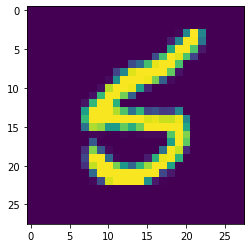

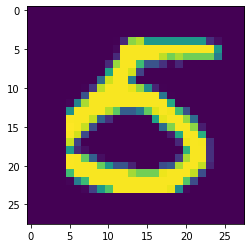

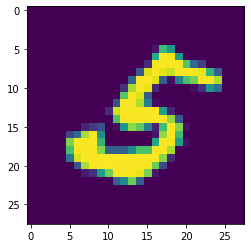

In [ ]:
# visualize the top images we sampled by entropy sampling
topK = 3
top_idx = strategy.query(topK)
for iter, idx in enumerate(top_idx):
    plt.figure()
    plt.imshow(X_train[idx].numpy())

## Least Confidence Sampling

The general idea of **Least Confidence Sampling** is that instead of randomly labeling data points, we choose to label the samples that we have the least confidence in.

In [ ]:
class LeastConfidence(Strategy):
    def __init__(self, X, Y, indexes, net, handler, args):
        super(LeastConfidence, self).__init__(X, Y, indexes, net, handler, args)

    def query(self, n):
        idxs_unlabeled = np.arange(self.n_pool)[~self.indexes]
        probs = self.predict_prob(self.X[idxs_unlabeled], self.Y[idxs_unlabeled])
        # return the maximum value of probabiliy in each sample
        U = probs.max(1)[0]
        # return the indices of samples that have low confidence score
        # sort() returns values and their corresponding indices in ascending order
        return idxs_unlabeled[U.sort()[1][:n]]

In [ ]:
# revert back to the initial labeled pool
indexes = np.zeros(n_pool, dtype=bool)
temp = np.arange(n_pool)
np.random.shuffle(temp)
indexes[temp[:NUM_INIT_LABEL]] = True

In [ ]:
# initiate a network
net = Net()
# initiate a LeastConfidence strategy
strategy = LeastConfidence(X_train, y_train, indexes, net, MNISTDataset, args)
strategy.train()
P = strategy.predict(X_test, y_test)
acc = np.zeros(NUM_ROUND+1)
acc[0] = 1.0 * (y_test==P).sum().item() / len(y_test)
print('Round 0\ntesting accuracy {}'.format(acc[0]))

for rd in range(1, NUM_ROUND+1):
    print('Round {}'.format(rd))
    # query
    q_idxs = strategy.query(NUM_QUERY)
    indexes[q_idxs] = True
    # update
    strategy.update(indexes)
    strategy.train()
    # round accuracy
    P = strategy.predict(X_test, y_test)
    acc[rd] = 1.0 * (y_test==P).sum().item() / len(y_test)
    print('testing accuracy {}'.format(acc[rd]))
# print results
print(type(strategy).__name__)
print('Average Accuracy: ' + str(np.mean(acc[1:])))

Round 0
testing accuracy 0.9511
Round 1
testing accuracy 0.9831
Round 2
testing accuracy 0.9878
Round 3
testing accuracy 0.9904
Round 4
testing accuracy 0.9897
Round 5
testing accuracy 0.99
LeastConfidence
Average Accuracy: 0.9882


As we expected, the accuracy of least confidence sampling is higher than that of random sampling.

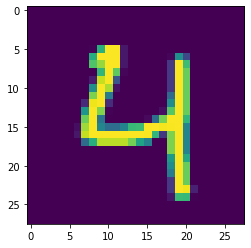

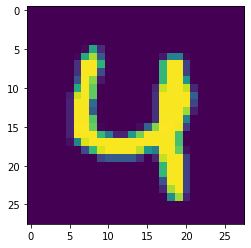

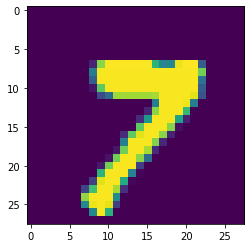

In [ ]:
# visualize the top images we sampled by entropy sampling
topK = 3
top_idx = strategy.query(topK)
for iter, idx in enumerate(top_idx):
    plt.figure()
    plt.imshow(X_train[idx].numpy())

## Margin Sampling

The intuitive idea of **Margin Sampling** is that we sample data points based on the difference between the two most confident predictions. That is, for the label that the model predicted, how much more confident was it than for the next most confident label? 

The greater the difference, the more confident we are in our predicted label. Then, the less information we could acquire by labeling it.

In [ ]:
class MarginSampling(Strategy):
    def __init__(self, X, Y, indexes, net, handler, args):
        super(MarginSampling, self).__init__(X, Y, indexes, net, handler, args)

    def query(self, n):
        idxs_unlabeled = np.arange(self.n_pool)[~self.indexes]
        probs = self.predict_prob(self.X[idxs_unlabeled], self.Y[idxs_unlabeled])
        # sort different labels by probability
        probs_sorted, idxs = probs.sort(descending=True)
        U = probs_sorted[:, 0] - probs_sorted[:,1]
        return idxs_unlabeled[U.sort()[1][:n]]

In [ ]:
# revert back to the initial labeled pool
indexes = np.zeros(n_pool, dtype=bool)
temp = np.arange(n_pool)
np.random.shuffle(temp)
indexes[temp[:NUM_INIT_LABEL]] = True

In [ ]:
# initiate a network
net = Net()
# initiate a LeastConfidence strategy
strategy = MarginSampling(X_train, y_train, indexes, net, MNISTDataset, args)
strategy.train()
P = strategy.predict(X_test, y_test)
acc = np.zeros(NUM_ROUND+1)
acc[0] = 1.0 * (y_test==P).sum().item() / len(y_test)
print('Round 0\ntesting accuracy {}'.format(acc[0]))

for rd in range(1, NUM_ROUND+1):
    print('Round {}'.format(rd))
    # query
    q_idxs = strategy.query(NUM_QUERY)
    indexes[q_idxs] = True
    # update
    strategy.update(indexes)
    strategy.train()
    # round accuracy
    P = strategy.predict(X_test, y_test)
    acc[rd] = 1.0 * (y_test==P).sum().item() / len(y_test)
    print('testing accuracy {}'.format(acc[rd]))
# print results
print(type(strategy).__name__)
print('Average Accuracy: ' + str(np.mean(acc[1:])))

Round 0
testing accuracy 0.9508
Round 1
testing accuracy 0.9842
Round 2
testing accuracy 0.9881
Round 3
testing accuracy 0.9901
Round 4
testing accuracy 0.9891
Round 5
testing accuracy 0.9895
MarginSampling
Average Accuracy: 0.9882


Again, the accuracy of margin sampling is higher than that of random sampling.

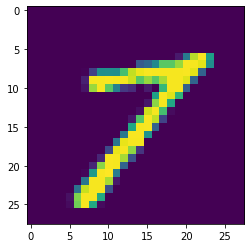

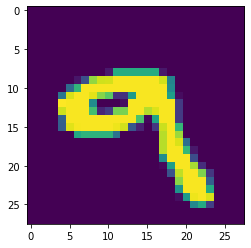

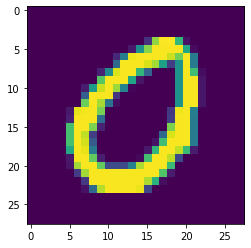

In [ ]:
# visualize the top images we sampled by entropy sampling
topK = 3
top_idx = strategy.query(topK)
for iter, idx in enumerate(top_idx):
    plt.figure()
    plt.imshow(X_train[idx].numpy())

## Questions

In [ ]:
#@markdown Out of the three methods above, which one gave you the best result(accuracy)?
q1 = '' #@param {type:"string"}
grader.grade(test_case_id = 'test_q1', answer = q1)

NameError: ignored

In [ ]:
#@markdown Change the number of original labeled data (NUM_INIT_LABEL) and the number of query data (NUM_QUERY) to 5000. 

#@markdown Observe the effect on performance. What trends or patterns do you observe? (Feel free to do more changes)
q2 = '' #@param {type:"string"}
grader.grade(test_case_id = 'test_q2', answer = q2)

Correct! You earned 1.0/1.0 points. You are a star!

Your submission has been successfully recorded in the gradebook.


In [ ]:
#@markdown We have visualized the top images we sampled by different methods. What insights could you get from these images?
q3 = '' #@param {type:"string"}
grader.grade(test_case_id = 'test_q3', answer = q3)


Correct! You earned 1.0/1.0 points. You are a star!

Your submission has been successfully recorded in the gradebook.
